In [1]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from pygam import LinearGAM, s, f
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import pickle

import joblib


#forecaster = gas_forecaster.ModelForecaster

with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load (f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load (f)
with open('test_y_df.pkl', 'rb') as f:
    test_y_df = pickle.load (f)
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load (f)


#unskalierte Werte
with open('unscaled_train_y_df.pkl', 'rb') as f:
    unscaled_train_y_df = pickle.load (f)
with open('unscaled_train_final_df.pkl', 'rb') as f:
    unscaled_train_final_df = pickle.load (f)
with open('unscaled_test_y.pkl', 'rb') as f:
    unscaled_test_y_df = pickle.load (f)
with open('unscaled_test_final_df.pkl', 'rb') as f:
    unscaled_test_final_df = pickle.load (f)
with open('diff_info.pkl', 'rb') as f:
    diff_info = pickle.load(f)

"""train_diff_order = diff_info['train_diff_order']
train_y_diff_order = diff_info['train_y_diff_order']
train_startwerte = diff_info['train_startwerte']
train_y_startwert = diff_info['train_y_startwert']"""

min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

X = train_df
y = train_y_df



## Ohne Tuning

MAE: 6.2987
RMSE: 7.1081
R²: -0.3323


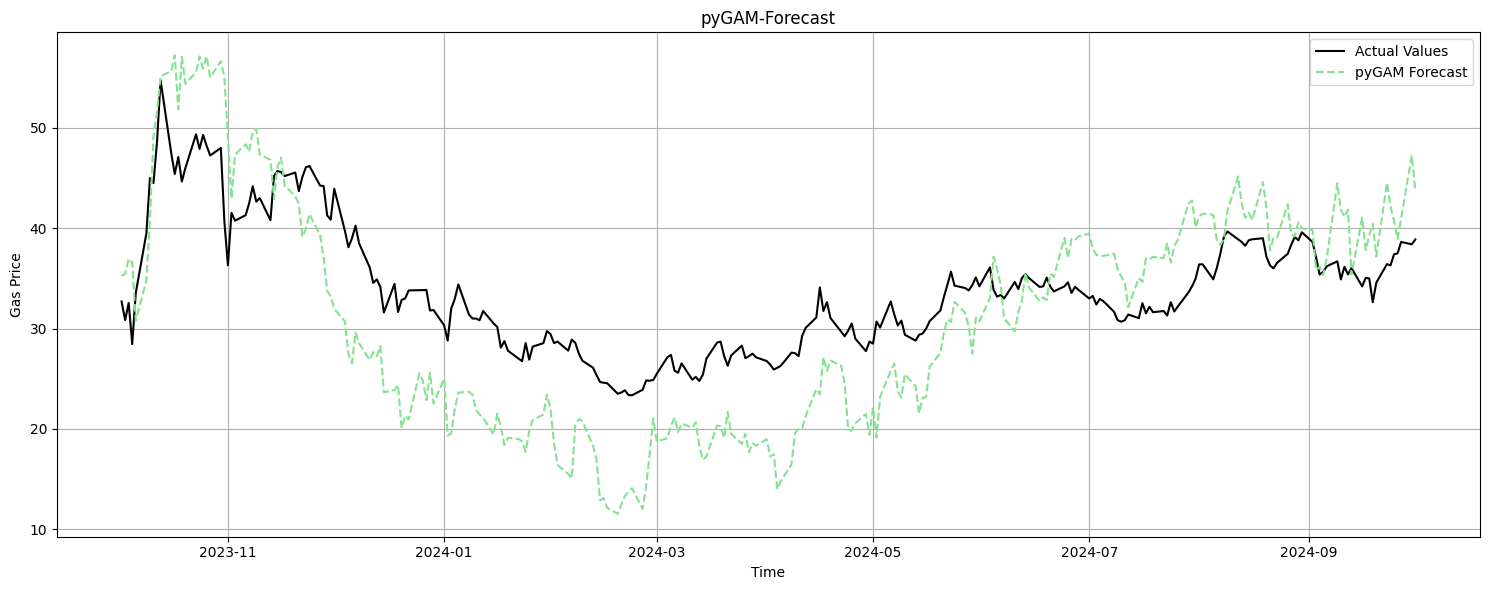

In [3]:


# Feature-Auswahl
selected_features_cb = [
    'S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7',
    'P-European_News_Index_rollmean_30', 'S-Oil Spot Price (Brent)',
    'S-Coal Price (close)_rollmean_3', 'N-Demand non-LDZ_lag30',
    'Season_Summer', 'N-Demand LDZ_rollstd_30', 'S-Coal Price (close)_rollstd_3'
]

X_train = train_df[selected_features_cb].values
y_train = train_y_df.values.ravel()
X_test = test_df[selected_features_cb].values
y_test = test_y_df.values.ravel()

# GAM-Modell definieren (nur stetige Features, keine Faktoren)
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9)).fit(X_train, y_train)

# Vorhersage
y_pred_scaled = gam.predict(X_test)
y_pred = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred))
r2 = r2_score(y_holdout_rescaled, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred, label='pyGAM Forecast', linestyle='--', color='#84E291')
plt.title('pyGAM-Forecast')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## mit Tuning

MAE: 46.3212
RMSE: 57.9216
R²: -87.4640
Beste Parameterkombination: lam=100, n_splines=20, max_iter=300


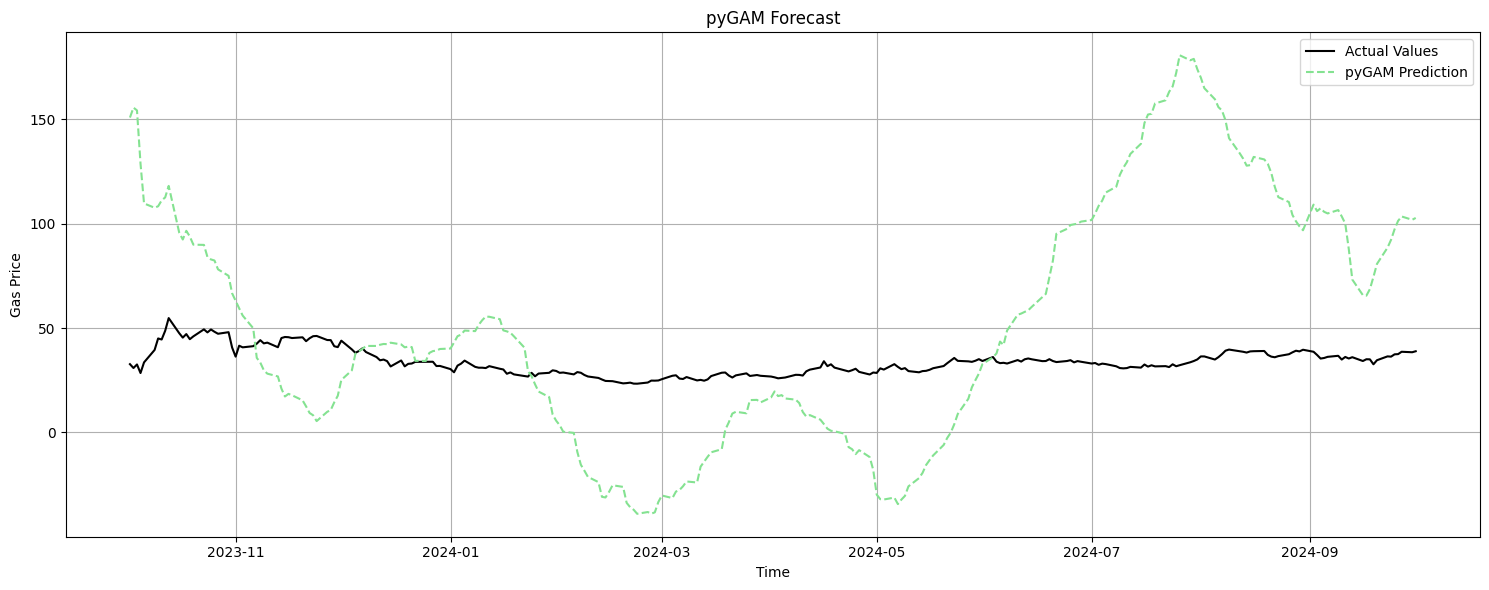

In [ ]:

import random
from itertools import product

# Feature-Auswahl
selected_features_cb = ['N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

X_train = train_df[selected_features_cb].values
y_train = train_y_df.values.ravel()
X_test = test_df[selected_features_cb].values
y_test = test_y_df.values.ravel()

# Hyperparameter-Kombinationen zufällig ziehen
param_grid = {
    'lam': [0.01, 0.1, 1, 10, 100],        
    'n_splines': [5, 10, 20, 40],           
    'max_iter': [100, 200, 300]             # Iterationsanzahl für Fit
}
param_list = list(product(param_grid['lam'], param_grid['n_splines'], param_grid['max_iter']))
random.shuffle(param_list)
param_list = param_list[:10]  # z. B. 10 zufällige Kombinationen

tscv = TimeSeriesSplit(n_splits=3)
best_score = float('inf')
best_model = None


for lam, n_splines, max_iter in param_list:
    model = LinearGAM(
        s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8)+s(9),
        lam=lam,
        n_splines=n_splines,
        max_iter=max_iter
    )
    val_scores = []
    for train_idx, val_idx in tscv.split(X_train):
        model.fit(X_train[train_idx], y_train[train_idx])
        y_val_pred = model.predict(X_train[val_idx])
        val_scores.append(mean_absolute_error(y_train[val_idx], y_val_pred))

    score = np.mean(val_scores)
    if score < best_score:
        best_score = score
        best_model = model
        best_params = (lam, n_splines, max_iter)


# Beste Modell auf Testdaten anwenden
y_pred_scaled = best_model.predict(X_test)
y_pred = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred))
r2 = r2_score(y_holdout_rescaled, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Beste Parameterkombination: lam={best_params[0]}, n_splines={best_params[1]}, max_iter={best_params[2]}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred, label='pyGAM Prediction', linestyle='--', color='#84E291')
plt.title('pyGAM Forecast')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [4]:
best_model.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     24.0551
Link Function:                     IdentityLink Log Likelihood:                               -564353.5612
Number of Samples:                          375 AIC:                                          1128757.2326
                                                AICc:                                         1128760.9742
                                                GCV:                                                0.0003
                                                Scale:                                              0.0003
                                                Pseudo R-Squared:                                   0.9921
Feature Function                  Lam

C:\Users\Lotta\AppData\Local\Temp\ipykernel_21476\1813810402.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  best_model.summary()


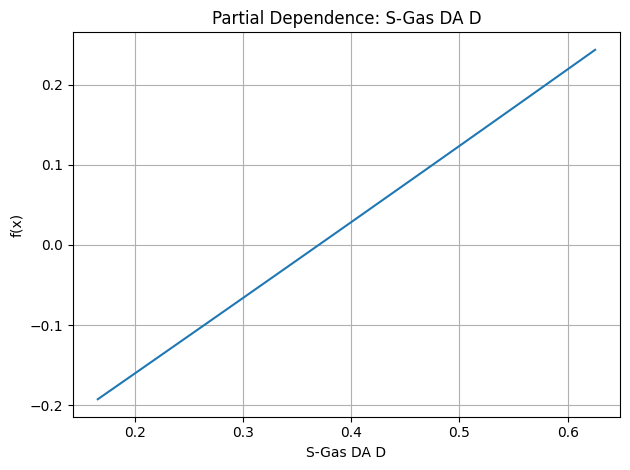

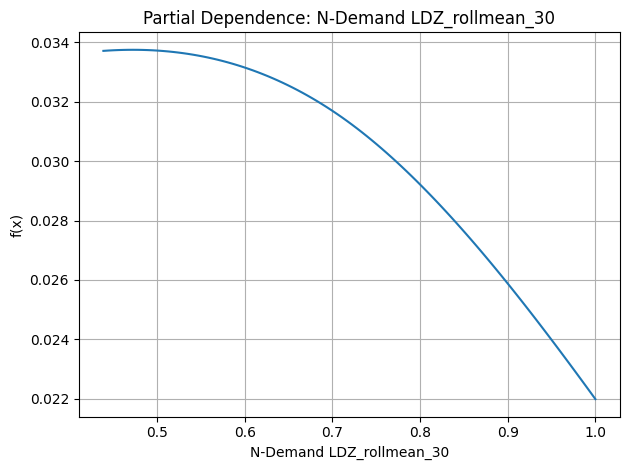

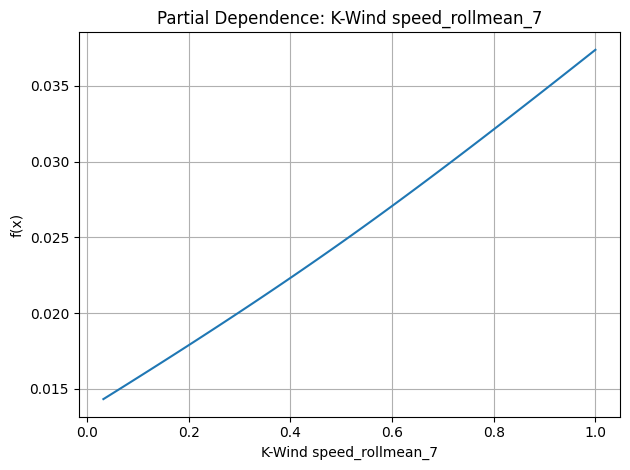

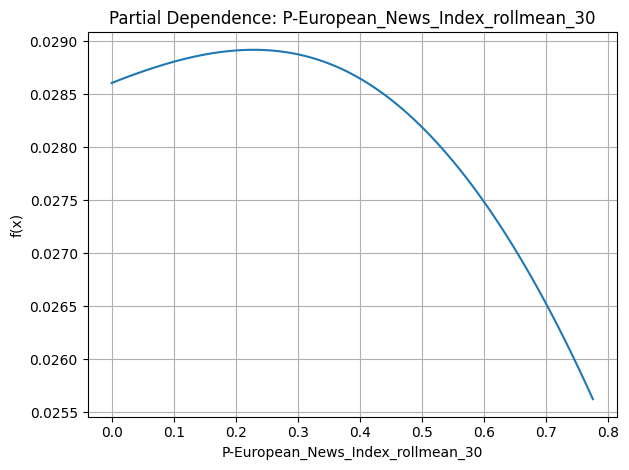

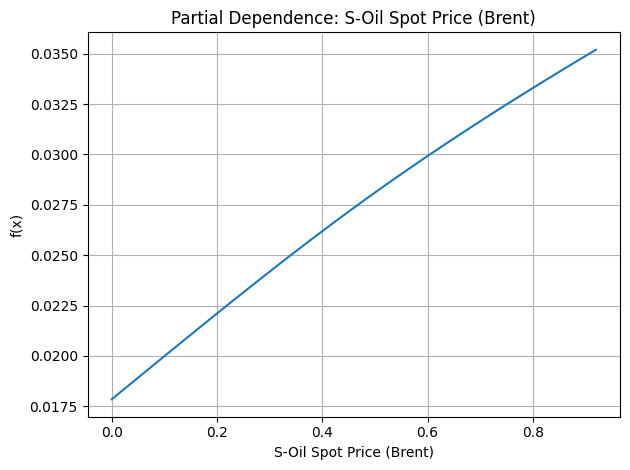

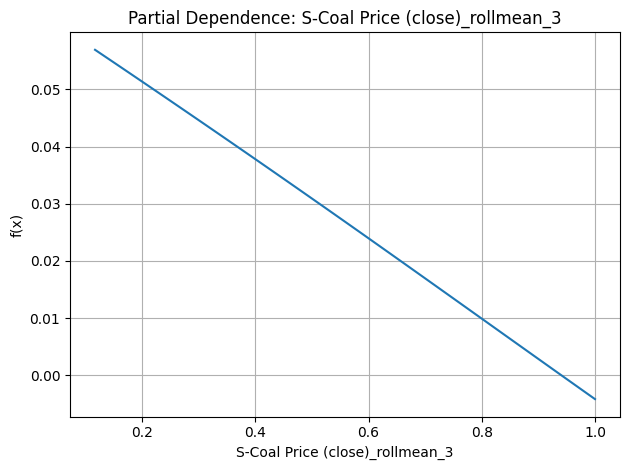

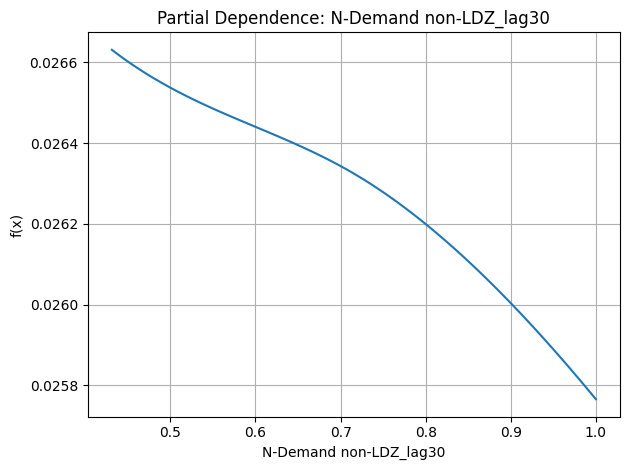

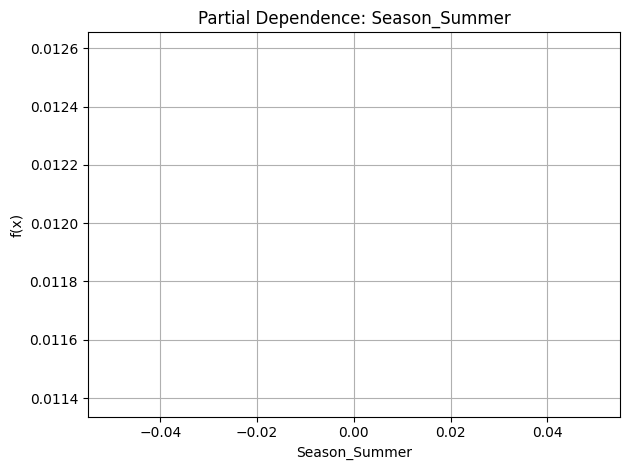

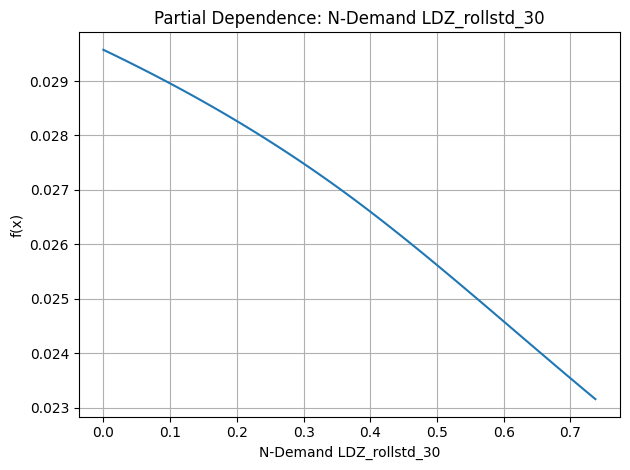

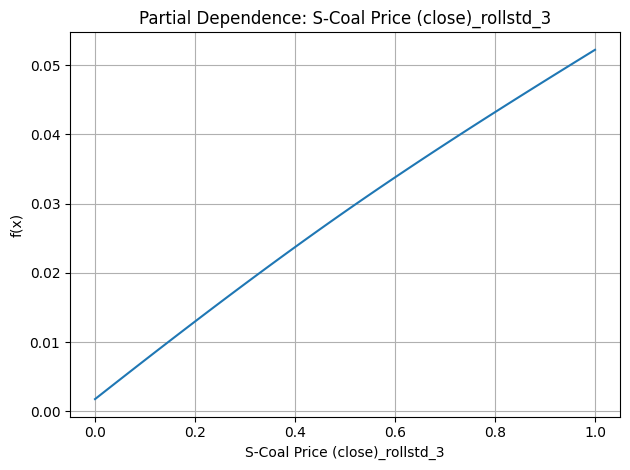

In [11]:
if best_model is None:
    raise RuntimeError("Es wurde kein best_model gefunden. Hyperparameter-Kombinationen prüfen.")

for i, term in enumerate(best_model.terms):
    if term.isintercept:
        continue
    plt.figure()
    XX = best_model.generate_X_grid(term=i)
    plt.plot(XX[:, i], best_model.partial_dependence(term=i, X=XX))
    plt.title(f'Partial Dependence: {selected_features_cb[i]}')
    plt.xlabel(selected_features_cb[i])
    plt.ylabel('f(x)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
